# Tutorial 05: Homework

### Assignement
  * For the attached data (cleaned data from the 3rd tutorial) try to use linear regression (or ridge regression, if you will) AND decision tree regressor (or boosted tree) applied on features given by PCA.
  * Try to select as less as possible features so that the results are comparably good (in terms of RMSLE) to the results obtained in the 3rd tutorial (RMSLE around 0.12).
  * Experiment with the feature selection:
    * Has removing indicator or discrete features a positive influence?
    * Are the first principal components always the best choice?

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display, Markdown, Latex
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats, optimize
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# loading data and copy data
data = pd.read_csv('dataHW05.csv', index_col=0)
dataDropIndicators = data.copy()
dataDropDiscrete = data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Columns: 327 entries, Id to SaleCondition_Partial
dtypes: float64(32), int64(295)
memory usage: 3.7 MB


In [3]:
# Drop indicators column - max 2 unique values
for i in dataDropIndicators.columns:
    if dataDropIndicators[i].nunique() <= 2:
        dataDropIndicators = dataDropIndicators.drop(i, axis=1)
#print(dataDropIndicators.info())

In [4]:
# Drop all discrete values
for i in dataDropDiscrete.columns:
    if dataDropDiscrete[i].dtype == 'int64':
        dataDropDiscrete = dataDropDiscrete.drop(i, axis=1)
#print(dataDropDiscrete.info())
# Center
dataDropDiscrete = dataDropDiscrete - dataDropDiscrete.mean()

In [5]:
# For no error in PCA
def convert_to_float(data):
    data[data.select_dtypes(['float16', 'float64', 'int64']).columns] = \
    data[data.select_dtypes(['float16', 'float64', 'int64']).columns].astype('float64')
    
convert_to_float(data)
convert_to_float(dataDropIndicators)

# spliting data to train and test datasets
def split_data(data):
    dtrain, dtest = train_test_split(data, test_size=0.25, random_state=11)
    X = dtrain.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = dtrain.SalePrice
    Xtest = dtest.drop(['SalePrice'], axis = 1, errors = 'ignore')
    ytest = dtest.SalePrice
    return X, y, Xtest, ytest

dataClean = split_data(data)
dataDI = split_data(dataDropIndicators)
dataDD = split_data(dataDropDiscrete)

In [6]:
# Test for select regresor 
def test(clf, X, y, Xtest, ytest):
    clf.fit(X, y)
    return np.sqrt(mean_squared_error(clf.predict(Xtest), ytest))

In [7]:
display(Markdown('### Linear regresion root mean squared logarithmic error:'))
print('- on cleaned data:', test(LinearRegression(), *dataClean))
print('- on data with dropped indicators:', test(LinearRegression(), *dataDI))
print('- on data with drop discrete attributes:', test(LinearRegression(), *dataDD))

### Linear regresion root mean squared logarithmic error:

- on cleaned data: 0.15659599544337202
- on data with dropped indicators: 0.12853979339558194
- on data with drop discrete attributes: 0.17552852491629953


In [8]:
display(Markdown('### Decision tree root mean squared logarithmic error:'))
print('- on cleaned data:', test(DecisionTreeRegressor(), *dataClean))
print('- on data with dropped indicators:', test(DecisionTreeRegressor(), *dataDI))
print('- on data with drop discrete attributes:', test(DecisionTreeRegressor(), *dataDD))

### Decision tree root mean squared logarithmic error:

- on cleaned data: 0.21114764792140442
- on data with dropped indicators: 0.21583297809018914
- on data with drop discrete attributes: 0.2430833376712937


In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# Do PCA a try to select the best number of components. The print plot for the components and print the best.
def do_pca_train_plot(maxComponets, X, y, Xtest, ytest):
    lotData = []

    # Minimum
    minLinreg = [1, 0]
    minTree = [1, 0]
    minLinregScale = [1, 0]
    minTreeScale = [1, 0]

    # Fit PCA on train and transform the train and test
    pca = PCA()
    pca.fit(X)
    _X = pca.transform(X)
    _Xtest = pca.transform(Xtest)
    
    # Same on scale data
    pca.fit(scale(X))
    _XS = pca.transform(scale(X))
    _XtestS = pca.transform(scale(Xtest))
    
    for i in range(1, maxComponets):
        Xsub1 = _X[:,0:i]
        Xsubtest1 = _Xtest[:,0:i]
    
        Xsub2 = _XS[:,0:i]
        Xsubtest2 = _XtestS[:,0:i]
    
        linreg = test(LinearRegression(), Xsub1, y, Xsubtest1, ytest)
        tree = test(DecisionTreeRegressor(), Xsub1, y, Xsubtest1, ytest)
        linregScale = test(LinearRegression(), Xsub2, y, Xsubtest2, ytest)
        treeScale = test(DecisionTreeRegressor(), Xsub2, y, Xsubtest2, ytest)
    
        if linreg < minLinreg[0]: minLinreg = [linreg, i]
        if tree < minTree[0]: minTree = [tree, i]
        if linregScale < minLinregScale[0]: minLinregScale = [linregScale, i]
        if treeScale < minTreeScale[0]: minTreeScale = [treeScale, i]
        lotData.append([i,test(LinearRegression(), X, y, Xtest, ytest), 
                        test(DecisionTreeRegressor(), X, y, Xtest, ytest), 
                        linreg, tree, linregScale, treeScale])
        #lotData.append([i, linreg, tree])
    
    df = pd.DataFrame(lotData)
    df.set_index(0, inplace=True)
    df.columns = ['Not fit PCA tree', 'Not fit PCA linReg', 'PCA_reg', 'PCA_tree', 'PCA_regS', 'PCA_treeS']
    #df.columns = ['PCA_reg', 'PCA_tree']
    df.plot(figsize=(15, 10))
    return minLinreg, minTree, minLinregScale, minTreeScale

### PCA plot on cleaned data, but with all attributes.Below are print the best value of error for a concrete method or on scaled data.There are print the line with not use PCA.

Minimum linear regresion RMSLE: 0.12308455794898937. Select components: 127
Minimum decision tree RMSLE: 0.2284320180464132. Select components: 47
Minimum linear regresion RMSLE on scaled the data: 0.12778194126636408. Select components: 52
Minimum decision tree RMSLE on the scaled: 0.1924229186635571. Select components: 6


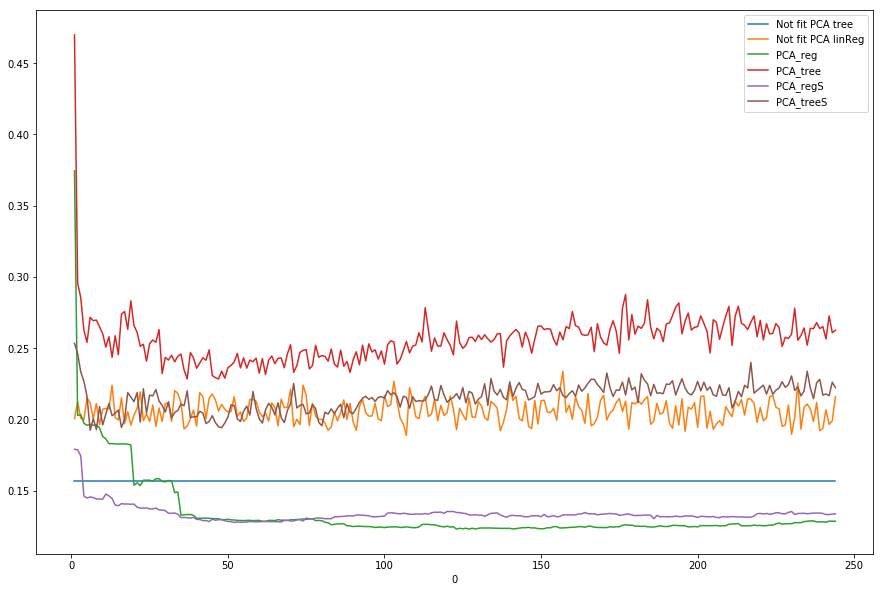

In [10]:
display(Markdown('### PCA plot on cleaned data, but with all attributes.\
Below are print the best value of error for a concrete method or on scaled data.\
There are print the line with not use PCA.'))
minLinreg, minTree, minLinregScale, minTreeScale = do_pca_train_plot(245, *dataClean)
print("Minimum linear regresion RMSLE: ", minLinreg[0], ". Select components: ", minLinreg[1], sep="")
print("Minimum decision tree RMSLE: ", minTree[0], ". Select components: ", minTree[1], sep="")
print("Minimum linear regresion RMSLE on scaled the data: ", minLinregScale[0], 
      ". Select components: ", minLinregScale[1], sep="")
print("Minimum decision tree RMSLE on the scaled: ", minTreeScale[0], ". Select components: ", minTreeScale[1], sep="")

### PCA plot on cleaned data, but with all attributes.Below are print the best value of error for a concrete method or on scaled data.There are print the line with not use PCA.

Minimum linear regresion RMSLE: 0.19409235561216412. Select components: 9
Minimum decision tree RMSLE: 0.26001615621577706. Select components: 4
Minimum linear regresion RMSLE on scaled the data: 0.14413071012038448. Select components: 9
Minimum decision tree RMSLE on the scaled: 0.17704650645489417. Select components: 8


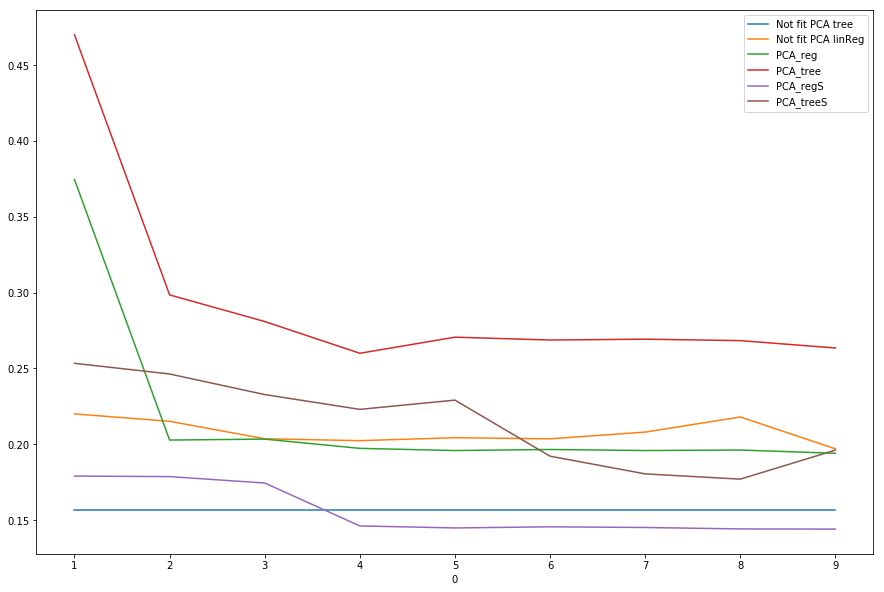

In [11]:
display(Markdown('### PCA plot on cleaned data, but with all attributes.\
Below are print the best value of error for a concrete method or on scaled data.\
There are print the line with not use PCA.'))
minLinreg, minTree, minLinregScale, minTreeScale = do_pca_train_plot(10, *dataClean)
print("Minimum linear regresion RMSLE: ", minLinreg[0], ". Select components: ", minLinreg[1], sep="")
print("Minimum decision tree RMSLE: ", minTree[0], ". Select components: ", minTree[1], sep="")
print("Minimum linear regresion RMSLE on scaled the data: ", minLinregScale[0], 
      ". Select components: ", minLinregScale[1], sep="")
print("Minimum decision tree RMSLE on the scaled: ", minTreeScale[0], ". Select components: ", minTreeScale[1], sep="")

### PCA plot on cleaned data, where I drop the indicators.Below are print the best value of error for a concrete method or on scaled data.There are print the line with not use PCA.

Minimum linear regresion RMSLE: 0.12771961049255035. Select components: 59
Minimum decision tree RMSLE: 0.22653874091502907. Select components: 39
Minimum linear regresion RMSLE on scaled the data: 0.12777853507055656. Select components: 56
Minimum decision tree RMSLE on the scaled: 0.1824334361230982. Select components: 53


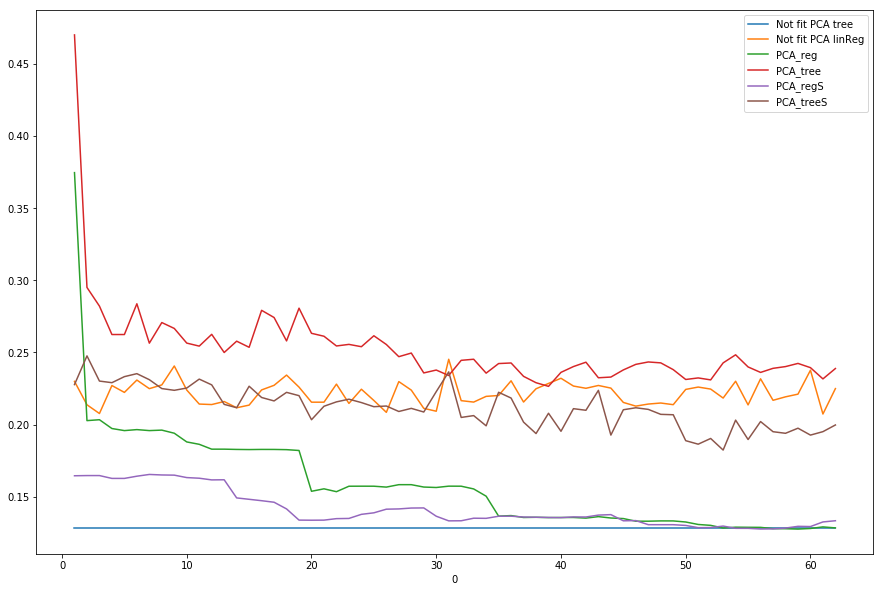

In [12]:
display(Markdown('### PCA plot on cleaned data, where I drop the indicators.\
Below are print the best value of error for a concrete method or on scaled data.\
There are print the line with not use PCA.'))
minLinreg, minTree, minLinregScale, minTreeScale = do_pca_train_plot(63, *dataDI)
print("Minimum linear regresion RMSLE: ", minLinreg[0], ". Select components: ", minLinreg[1], sep="")
print("Minimum decision tree RMSLE: ", minTree[0], ". Select components: ", minTree[1], sep="")
print("Minimum linear regresion RMSLE on scaled the data: ", minLinregScale[0], 
      ". Select components: ", minLinregScale[1], sep="")
print("Minimum decision tree RMSLE on the scaled: ", minTreeScale[0], ". Select components: ", minTreeScale[1], sep="")

### PCA plot on cleaned data, where I drop the discrete attributes.Below are print the best value of error for a concrete method or on scaled data.There are print the line with not use PCA.

Minimum linear regresion RMSLE: 0.17404652664726633. Select components: 28
Minimum decision tree RMSLE: 0.2557118432010127. Select components: 20
Minimum linear regresion RMSLE on scaled the data: 0.1729190801734667. Select components: 30
Minimum decision tree RMSLE on the scaled: 0.25372917624597396. Select components: 32


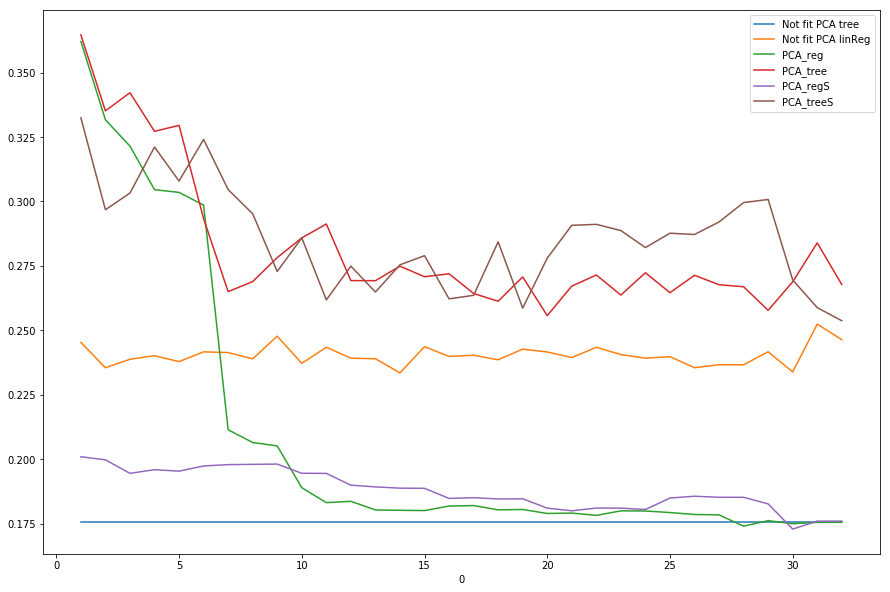

In [13]:
display(Markdown('### PCA plot on cleaned data, where I drop the discrete attributes.\
Below are print the best value of error for a concrete method or on scaled data.\
There are print the line with not use PCA.'))
minLinreg, minTree, minLinregScale, minTreeScale = do_pca_train_plot(33, *dataDD)
print("Minimum linear regresion RMSLE: ", minLinreg[0], ". Select components: ", minLinreg[1], sep="")
print("Minimum decision tree RMSLE: ", minTree[0], ". Select components: ", minTree[1], sep="")
print("Minimum linear regresion RMSLE on scaled the data: ", minLinregScale[0], 
      ". Select components: ", minLinregScale[1], sep="")
print("Minimum decision tree RMSLE on the scaled: ", minTreeScale[0], ". Select components: ", minTreeScale[1], sep="")

### Results
1. In graphs, I've always rendered every method to normal and then scaled data and always applied a line of error that is not using PCA. In charts where data without indicators or non-discrete attributes fails to achieve improvement by selecting features. Linear regression has the same error when not use PCA or select all components.

    In the decision tree, it can be seen that even the reference value is not constant. This will probably be caused by accidentally cutting a tree or ending it.

    For linear regression, where I left the indicators in data, I am able to achieve 0.123 RMSLE with selecting components with PCA on not scaled data. For the best RMSLE, **I choose 127 components from more than 260.**

    Under the plot, I made a selection of the chart for the first ten components. Here, you can see that the choice of components will be below the value of the solution without selection. This has already been done for four components. **But the error is still around 0.14 compared to the required approximate 0.12. Therefore, according to the chart, I would choose the number of components higher than 50 to 127, where the best error was achieved near 0.12.**



2. First main component may not always be the best choice. The first component is not selected based on the data, but only by the highest variance in the given direction. However, this component may not be in relation to the predicted attribute.

